In [1]:
import mne
import os
import autoreject as aj
import numpy as np
import pandas as pd
from pathlib import Path
from io import StringIO

DATA_PATH = Path(os.getenv("DATA_PATH"))

### Functions

In [2]:
def autoreject(epochs, raw):
    picks = mne.pick_types(
        raw.info,
        eeg=False,
        stim=False,
        eog=False,
        include=["C3", "C4", "POz", "FCz"],
        exclude=[],
    )
    ar = aj.AutoReject()

    # Fit on the first 20 epochs to save time
    ar.fit(epochs[0:20])
    epochs_ar, reject_log = ar.transform(epochs, return_log=True)

    return epochs_ar


# Given a tuple of ndarrays (index 0 containing event, index 1 containing time)
# Return fixed events
def merge_events_stim(stim):
    stim_new = stim[0].copy()
    mapping = {
        # stim/t1
        12: 11,
        20: 11,
        21: 11,
        22: 11,
        23: 11,
        31: 11,
        32: 11,
        # stim/t2
        65: 64,
        66: 64,
        67: 64,
        68: 64,
        128: 64,
        129: 64,
        130: 64,
        131: 64,
        132: 64,
        133: 64,
        # response/t1
        2: 1,
        3: 1,
        # response/t2
        5: 4,
        # block
        7: 6,
    }
    for k, v in mapping.items():
        stim_new[stim[0] == k] = v
    return stim_new


def find_condition(events):
    # If stim_t2 occurs within 300 or 1200ms from stim_t1, include condition
    # Otherwise exclude that stim_t1 timepoint
    new_events = []

    stims_t1 = events[events[:, 2] == 11, 0]
    stims_t2 = events[events[:, 2] == 64, 0]

    # Identify short/long SOA based on time between stims
    for idx, onset in enumerate(stims_t1):
        diffs = stims_t2[stims_t2 > onset] - onset
        # diffs[0] is distance (in samples?) to closest t2 stim
        if 600 < diffs[0] < 615:  # Most often 602/603
            # Long SOA
            new_events.append([onset, 0, 256])
        elif 140 < diffs[0] < 151:  # Most often 141/142/143
            # Short SOA
            new_events.append([onset, 0, 512])
        else:
            # Invalid
            new_events.append([onset, 0, 1024])
    return new_events


def get_events(raw, tmin, tmax):
    stimulus_id = {"stimulus/t1": 11, "stimulus/t2": 64}  # Stimulus trigger
    condition_id = {"condition/short": 512, "condition/long": 256}  # Condition trigger
    response_id = {"response/t2": 4, "response/t1": 1}  # Response triggers
    block_id = 6  # Block trigger
    event_id = condition_id | stimulus_id | response_id  # All retained events

    # Correct event trigger values in raw data
    stim_idx = raw.ch_names.index("Status")
    raw._data[stim_idx] = merge_events_stim(raw["Status"])

    # IMPORTANT, set consecutive=True so not only ascending trigger values are recorded as new events
    events = mne.find_events(raw, shortest_event=1, consecutive=True)
    # mne.viz.plot_events(events, sfreq=raw.info["sfreq"])

    # find_condition adds condition trigger
    new_events = np.array(find_condition(events))
    # 1, 4, 6, 11, 16, 64
    # mne.viz.plot_events(new_events, sfreq=raw.info["sfreq"])

    # Append events to end of array, now has events 256/512 at same onset, but later in array
    events_tmp = np.concatenate((events, new_events))
    mne.viz.plot_events(events_tmp, sfreq=raw.info["sfreq"])

    # Makes for every event in row_events (11/64, stim/t1 and stim/t2)
    # a row containing all other events (condition, response)
    metadata, events, event_id = mne.epochs.make_metadata(
        events=events_tmp,
        event_id=event_id,
        tmin=tmin,
        tmax=tmax,
        sfreq=raw.info["sfreq"],
        row_events=list(stimulus_id.keys()),
        keep_first=["condition"],
    )

    # Add block information to metadata
    block_samples = events_tmp[events_tmp[:, 2] == block_id, 0]

    def time_until_next_block(sample):
        # Find the next block sample
        next_block = block_samples[block_samples > sample]
        if len(next_block) > 0:
            time_to_next = (next_block[0] - sample) / raw.info["sfreq"]
            block_idx = np.where(block_samples == next_block[0])[0][0] + 1
            return (time_to_next, block_idx)
        else:
            return np.nan

    # Time in seconds until block end and n-th block
    metadata[["time_until_block", "block_idx"]] = [
        time_until_next_block(sample) for sample in events[:, 0]
    ]
    metadata["block_idx"] = metadata["block_idx"].astype(int)

    # keep_first causes first_condition to be set for stim/t2 based on the NEXT trial
    # if 'condition' is not 0 (condition was not set at the same time as event), set first_condition to shift(1) value (previous row)
    metadata.loc[(metadata["condition"] != 0), "first_condition"] = metadata[
        "first_condition"
    ].shift(1)

    # Trial is valid if first_condition is not None AND response/t1 is not NaN AND response/t2 is not NaN, in these cases we know that there was ~300/1200ms between stimuli and responses were given in the time between stim/t1 and next stim/t1
    metadata.loc[metadata["event_name"] == "stimulus/t1", "valid"] = (
        metadata["first_condition"].notna()
        & metadata["response/t1"].notna()
        & metadata["response/t2"].notna()
    )

    # t2 'trials' are valid when the previous row was stim/t1 and it was valid, AND response/t2 is not na
    metadata.loc[metadata["event_name"] == "stimulus/t2", "valid"] = (
        (metadata["event_name"].shift(1) == "stimulus/t1")
        & (metadata["valid"].shift(1) == True)
        & (metadata["response/t2"].notna())
    )

    metadata = metadata.reset_index(drop=True)

    trial_index = 0
    # Assign trial index to each row, the same number for every stimulus/t1 that is followed by a stimulus/t2
    for row in metadata.itertuples():
        if row.event_name == "stimulus/t1":
            metadata.at[row.Index, "trial_index"] = trial_index
            trial_index += 1
        elif row.event_name == "stimulus/t2":
            if metadata.at[row.Index - 1, "event_name"] == "stimulus/t1":
                metadata.at[row.Index, "trial_index"] = trial_index - 1
            else:
                metadata.at[row.Index, "trial_index"] = trial_index
                trial_index += 1
    metadata["trial_index"] = metadata.trial_index.astype(int)

    # find stim/t1 and stim/t2 indices
    s1_indices = metadata[
        (metadata["event_name"] == "stimulus/t1") & (metadata["valid"] == True)
    ].index.tolist()
    s2_indices = metadata[
        (metadata["event_name"] == "stimulus/t2") & (metadata["valid"] == True)
    ].index.tolist()

    return events, metadata, s1_indices, s2_indices


def add_response_information(metadata, logs):
    # Pre-group logs by block_idx for faster access
    logs_by_block = {k: v for k, v in logs.groupby("block_idx")}
    meta_by_block = {k: v for k, v in metadata.groupby("block_idx")}

    corrects = [None] * len(metadata)
    meta_idx = metadata.index

    for block_idx, meta_block in meta_by_block.items():
        log_block = logs_by_block.get(block_idx)
        if log_block is None:
            continue

        # Pre-filter for Picture and Sound rows
        picture_rows = log_block[
            (log_block["Event Type"] == "Picture")
            & (log_block["Code"].astype(str).str.startswith("c", na=False))
        ]
        sound_rows = log_block[log_block["Event Type"] == "Sound"]

        # Precompute next Picture/Sound indices for each
        picture_indices = picture_rows.index.to_numpy()
        sound_indices = sound_rows.index.to_numpy()

        for idx, row in meta_block.iterrows():
            time_until_block = row.time_until_block

            if row["event_name"] == "stimulus/t1":
                if not picture_rows.empty:
                    # Find closest Picture row
                    closest_picture_idx = (
                        (picture_rows["Time Until Block"] - time_until_block)
                        .abs()
                        .idxmin()
                    )
                    closest_row = picture_rows.loc[closest_picture_idx]
                    # Get next Response row with code 1, 2, or 3
                    response_rows = log_block[
                        (log_block.index > closest_picture_idx)
                        & (log_block["Event Type"] == "Response")
                        & (log_block["Code"].isin(["1", "2", "3"]))
                    ]
                    # Find the next Picture row after closest_row
                    next_picture_idx = picture_indices[picture_indices > closest_picture_idx]
                    if next_picture_idx.size > 0:
                        response_rows = response_rows[
                            response_rows.index < next_picture_idx[0]
                        ]
                    if not response_rows.empty:
                        # Correct if response code (1/2/3) is equal to the first number in the Picture row (c[123][123][123])
                        corrects[meta_idx.get_loc(idx)] = (
                            response_rows["Code"].values[0] == str(closest_row["Code"])[1]
                        )
                    else:
                        corrects[meta_idx.get_loc(idx)] = False
                else:
                    corrects[meta_idx.get_loc(idx)] = None

            elif row["event_name"] == "stimulus/t2":
                if not sound_rows.empty:
                    closest_sound_idx = (
                        (sound_rows["Time Until Block"] - time_until_block)
                        .abs()
                        .idxmin()
                    )
                    closest_row = sound_rows.loc[closest_sound_idx]
                    response_rows = log_block[
                        (log_block.index > closest_sound_idx)
                        & (log_block["Event Type"] == "Response")
                        & (log_block["Code"].isin(["4", "5"]))
                    ]
                    next_sound_idx = sound_indices[sound_indices > closest_sound_idx]
                    if next_sound_idx.size > 0:
                        response_rows = response_rows[
                            response_rows.index < next_sound_idx[0]
                        ]
                    if not response_rows.empty:
                        if (
                            response_rows["Code"].values[0] == "4"
                            and str(closest_row["Code"]) == "s1"
                        ):
                            corrects[meta_idx.get_loc(idx)] = True
                        elif (
                            response_rows["Code"].values[0] == "5"
                            and str(closest_row["Code"]) == "s2"
                        ):
                            corrects[meta_idx.get_loc(idx)] = True
                        else:
                            corrects[meta_idx.get_loc(idx)] = False
                    else:
                        corrects[meta_idx.get_loc(idx)] = False
                else:
                    corrects[meta_idx.get_loc(idx)] = None
            else:
                corrects[meta_idx.get_loc(idx)] = None

    metadata["correct"] = corrects
    return metadata


def load_logs(path: Path):
    columns = [
        "Trial",
        "Event Type",
        "Code",
        "Time",
        "TTime",
        "Uncertainty1",
        "Duration",
        "Uncertainty2",
        "ReqTime",
        "ReqDur",
        "Stim Type",
        "Pair Index",
    ]
    logs = []

    for log in path.glob("*.log"):
        with open(log) as f:
            lines = []
            for line in f:
                if line.startswith("The following output"):
                    break
                lines.append(line)

        df = pd.read_csv(StringIO("".join(lines)), skiprows=5, sep="\s+", names=columns)
        df["Time Until Block"] = (df["Time"].iloc[-1] - df["Time"]) / 10000
        df["block_idx"] = int(log.name.split(".")[0].split("k")[1])
        logs.append(df)
    logs = pd.concat(logs, ignore_index=True)
    return logs


def create_epochs_t1(tmin, tmax, raw, logs_path):
    events, metadata, s1_indices, _ = get_events(raw, tmin, tmax)

    logs = load_logs(logs_path / raw.filenames[0].name.split("_")[2])
    metadata = add_response_information(metadata, logs)

    s1_indices = [i for i in s1_indices]

    metadata = metadata.iloc[s1_indices]
    events = [events[i] for i in s1_indices]
    keep_cols = ["response/t1", "first_condition", "trial_index", "stimulus/t2", "correct"]
    metadata = metadata[keep_cols]
    metadata.reset_index(
        drop=True, inplace=True
    )  # This allows to preserve the trial number after the rejections performed by the mne.Epochs function
    metadata.columns = [
        "rt",
        "condition",
        "trial_index",
        "interval",
        "correct",
    ]  # More convenient names
    event_id = {"stimulus/t1": 11}  # S1 will be the onset of the epochs

    # Create epochs
    epochs = mne.Epochs(
        raw,
        events,
        event_id,
        tmin,
        tmax,
        proj=False,
        baseline=(None, 0),
        preload=True,
        verbose=True,
        detrend=1,
        on_missing="warn",
        event_repeated="drop",
        metadata=metadata,
        reject_by_annotation=True,
        reject=None,
    )

    return epochs, events


def create_epochs_t2(tmin, tmax, raw, logs_path):
    events, metadata, _, s2_indices = get_events(raw, tmin, tmax)

    s2_indices = [i for i in s2_indices]

    logs = load_logs(logs_path / raw.filenames[0].name.split("_")[2])
    metadata = add_response_information(metadata, logs)
    
    metadata = metadata.iloc[s2_indices]
    events = [events[i] for i in s2_indices]
    keep_cols = ["response/t2", "first_condition", "trial_index", "correct"]
    metadata = metadata[keep_cols]
    metadata.reset_index(
        drop=True, inplace=True
    )  # This allows to preserve the trial number after the rejections performed by the mne.Epochs function
    metadata.columns = ["rt", "condition", "trial_index", "correct"]  # More convenient names
    event_id = {"stimulus/t2": 64}  # S1 will be the onset of the epochs

    # Create epochs
    epochs = mne.Epochs(
        raw,
        events,
        event_id,
        tmin,
        tmax,
        proj=False,
        baseline=(None, 0),
        preload=True,
        verbose=True,
        detrend=1,
        on_missing="warn",
        event_repeated="drop",
        metadata=metadata,
        reject_by_annotation=True,
        reject=None,
    )

    return epochs, events

def create_epochs_combined(tmin, tmax, raw, logs_path):
    events, metadata, s1_indices, _ = get_events(raw, tmin, tmax)

    logs = load_logs(logs_path / raw.filenames[0].name.split("_")[2])
    metadata = add_response_information(metadata, logs)
    # Set correct_t1 and correct_t2
    metadata["correct_t1"] = metadata["correct"]
    # Set correct_t2 at rows where event_name is stimulus/t1 to the value of correct at the row with the same trial_index
    # Find correct value for stimulus/t2 with the same trial_index
    trial_to_correct_t2 = (
        metadata[metadata["event_name"] == "stimulus/t2"]
        .set_index("trial_index")["correct"]
        .to_dict()
    )
    metadata["correct_t2"] = metadata.apply(
        lambda row: trial_to_correct_t2.get(row["trial_index"], None)
        if row["event_name"] == "stimulus/t1"
        else None,
        axis=1,
    )

    s1_indices = [i for i in s1_indices]

    metadata = metadata.iloc[s1_indices]
    events = [events[i] for i in s1_indices]
    keep_cols = ["response/t2", "first_condition", "trial_index", "stimulus/t2", "correct_t1", "correct_t2", "response/t1"]
    metadata = metadata[keep_cols]
    metadata.reset_index(
        drop=True, inplace=True
    )  # This allows to preserve the trial number after the rejections performed by the mne.Epochs function
    metadata.columns = [
        "rt",
        "condition",
        "trial_index",
        "interval",
        "correct_t1",
        "correct_t2",
        "rt_t1"
    ]  # More convenient names
    event_id = {"stimulus/t1": 11}  # S1 will be the onset of the epochs

    # Create epochs
    epochs = mne.Epochs(
        raw,
        events,
        event_id,
        tmin,
        tmax,
        proj=False,
        baseline=(None, 0),
        preload=True,
        verbose=True,
        detrend=1,
        on_missing="warn",
        event_repeated="drop",
        metadata=metadata,
        reject_by_annotation=True,
        reject=None,
    )

    return epochs, events

### Usage

In [3]:
path = DATA_PATH / "prp/post_ica"
out_path = DATA_PATH / "prp/epoched"
behavior_path = DATA_PATH / "prp/behavior"
subj_names = []

for file in path.glob("*"):
    if 'raw.fif' in file.name:
        subj_names.append(file.name.split('_')[2])

print(subj_names)

['VP6', 'VP8', 'VP5', 'VP3', 'VP24', 'VP13', 'VP16', 'VP11', 'VP23', 'VP21', 'VP18', 'VP10', 'VP19', 'VP17', 'VP15', 'VP9', 'VP7', 'VP22', 'VP20', 'VP1', 'VP12', 'VP14', 'VP2']


In [7]:
raw = mne.io.read_raw_fif(path / f"post_ica_VP2_raw.fif", preload=True, verbose=False)

Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6473 events found on stim channel Status
Event IDs: [ 1  4  6 11 16 64]


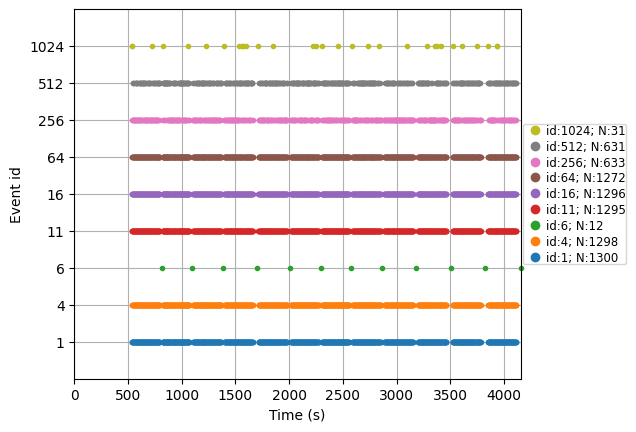

In [8]:
events, metadata, s1_indices, _, = get_events(raw, -.25, 2)

In [105]:
# Check t1 accuracy 
t1_rows = logs[(logs['Event Type'] == 'Picture') & (logs['Code'].str.startswith('c')) | ((logs['Event Type'] == 'Response') & (logs['Code'].isin(['1', '2', '3'])))]
# For every pair of t1_rows
correct = 0
total = 0
for i in range(len(t1_rows) - 1,):
    # Get the current and next row
    current_row = t1_rows.iloc[i]
    next_row = t1_rows.iloc[i + 1]
    # Check if the current row is a Picture and the next row is a Response
    if current_row['Event Type'] == 'Picture' and next_row['Event Type'] == 'Response':
        # Check if the Code of the current row starts with 'c'
        if current_row['Code'].startswith('c'):
            total += 1

            # Check if the Code of the next row is in ['1', '2', '3']
            if next_row['Code'] in ['1', '2', '3']:
                if current_row['Code'][1] == next_row['Code']:
                    correct += 1

print(correct / total)

    

0.7922779922779922


In [111]:
# Check t2 accuracy
t2_rows = logs[(logs['Event Type'] == 'Sound') | ((logs['Event Type'] == 'Response') & (logs['Code'].isin(['4', '5'])))]
# For every pair of t2_rows
correct = 0
total = 0

for i in range(len(t2_rows) - 1,):
    # Get the current and next row
    current_row = t2_rows.iloc[i]
    next_row = t2_rows.iloc[i + 1]
    # Check if the current row is a Sound and the next row is a Response
    if current_row['Event Type'] == 'Sound' and next_row['Event Type'] == 'Response':
        total += 1
        # Check if the Code of the next row is in ['4', '5']
        if next_row['Code'] in ['4', '5']:
            if current_row['Code'] == 's1' and next_row['Code'] == '4':
                correct += 1
            elif current_row['Code'] == 's2' and next_row['Code'] == '5':
                correct += 1
print(correct / total)

0.8819826907946499


Processing VP8
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
5944 events found on stim channel Status
Event IDs: [ 1  4  6 11 16 64]


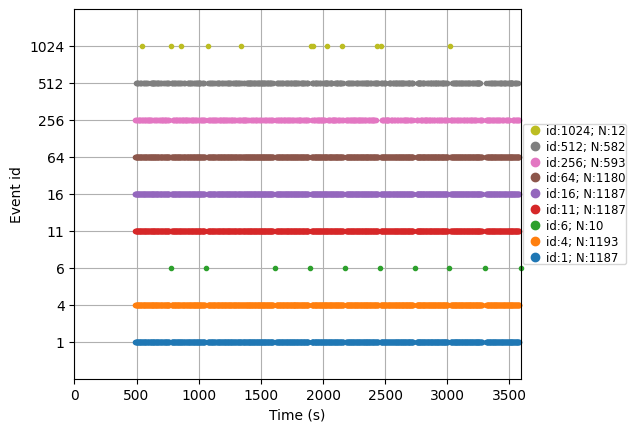

Adding metadata with 7 columns
1173 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1173 events and 2177 original time points ...
10 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.80 and n_interpolate=32


  0%|          | Repairing epochs : 0/1163 [00:00<?,       ?it/s]

Dropped 31 epochs: 25, 26, 101, 102, 329, 330, 803, 927, 928, 1026, 1027, 1030, 1031, 1081, 1082, 1104, 1105, 1106, 1131, 1132, 1133, 1135, 1136, 1141, 1142, 1151, 1152, 1153, 1154, 1155, 1158
Overwriting existing file.
Overwriting existing file.
Processing VP5
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6473 events found on stim channel Status
Event IDs: [ 1  4  6 11 16 64]


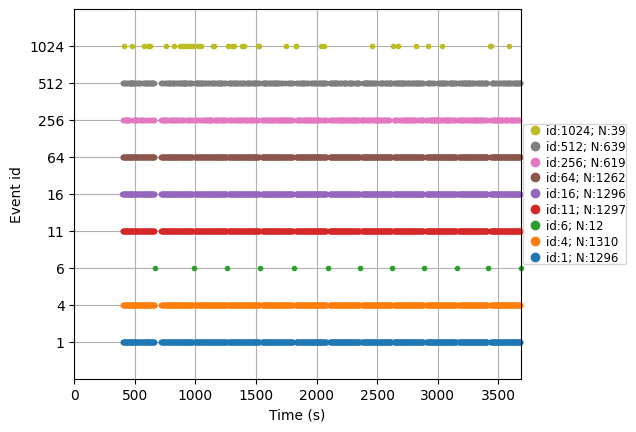

Adding metadata with 7 columns
1253 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1253 events and 2177 original time points ...
11 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1242 [00:00<?,       ?it/s]

Dropped 70 epochs: 24, 43, 44, 46, 54, 55, 56, 57, 58, 59, 65, 66, 67, 70, 71, 82, 83, 85, 86, 89, 90, 95, 96, 114, 130, 131, 132, 133, 136, 143, 144, 145, 151, 152, 153, 156, 157, 161, 162, 163, 164, 165, 178, 179, 191, 198, 225, 226, 227, 228, 249, 250, 257, 260, 261, 276, 277, 301, 314, 328, 361, 362, 399, 478, 479, 487, 593, 606, 1027, 1201
Overwriting existing file.
Overwriting existing file.
Processing VP3
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6495 events found on stim channel Status
Event IDs: [ 1  4  6 11 16 64]


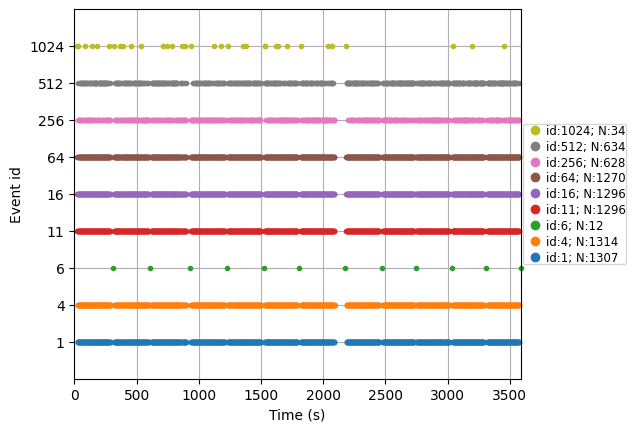

Adding metadata with 7 columns
1257 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1257 events and 2177 original time points ...
12 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1245 [00:00<?,       ?it/s]

Dropped 27 epochs: 100, 243, 338, 360, 361, 362, 381, 382, 439, 440, 545, 611, 669, 670, 697, 705, 751, 752, 790, 791, 873, 874, 1016, 1099, 1139, 1183, 1184
Overwriting existing file.
Overwriting existing file.
Processing VP24
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6470 events found on stim channel Status
Event IDs: [ 1  4  6 11 16 64]


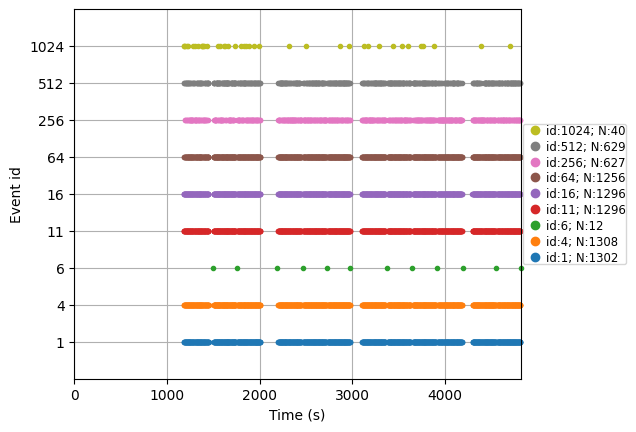

Adding metadata with 7 columns
1255 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1255 events and 2177 original time points ...
12 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=32


  0%|          | Repairing epochs : 0/1243 [00:00<?,       ?it/s]

Dropped 56 epochs: 37, 94, 95, 96, 172, 175, 176, 177, 195, 207, 209, 210, 291, 292, 308, 309, 362, 363, 494, 495, 565, 566, 612, 615, 616, 617, 618, 619, 630, 631, 656, 657, 667, 668, 716, 717, 718, 719, 726, 727, 820, 866, 911, 912, 914, 924, 1031, 1071, 1072, 1137, 1138, 1141, 1175, 1176, 1212, 1213
Overwriting existing file.
Overwriting existing file.
Processing VP13
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6480 events found on stim channel Status
Event IDs: [ 1  4  6 11 16 64]


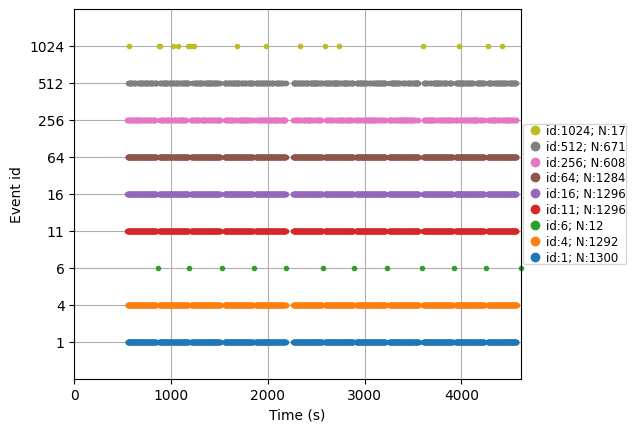

Adding metadata with 7 columns
1273 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1273 events and 2177 original time points ...
12 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1261 [00:00<?,       ?it/s]

Dropped 28 epochs: 55, 56, 205, 256, 415, 520, 521, 522, 523, 536, 548, 549, 692, 800, 801, 807, 808, 838, 840, 958, 968, 986, 987, 1033, 1073, 1074, 1083, 1128
Overwriting existing file.
Overwriting existing file.
Processing VP16
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6494 events found on stim channel Status
Event IDs: [ 1  4  6 11 16 64]


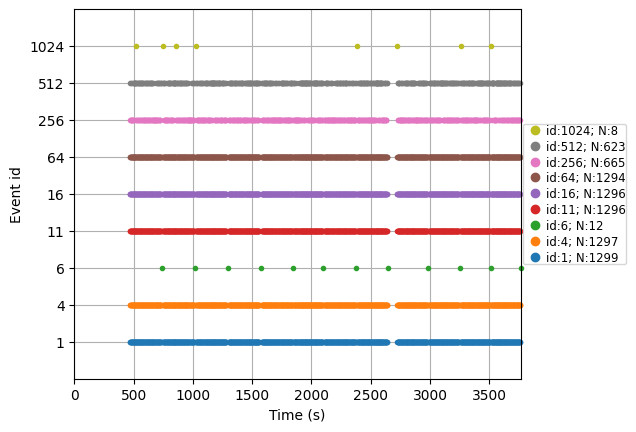

Adding metadata with 7 columns
1287 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1287 events and 2177 original time points ...
12 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1275 [00:00<?,       ?it/s]

Dropped 36 epochs: 243, 314, 315, 464, 578, 579, 607, 608, 687, 688, 703, 742, 743, 751, 752, 784, 785, 809, 810, 875, 876, 877, 924, 925, 930, 946, 947, 990, 991, 1041, 1150, 1151, 1211, 1231, 1232, 1272
Overwriting existing file.
Overwriting existing file.
Processing VP11
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6498 events found on stim channel Status
Event IDs: [ 1  4  6 11 16 64]


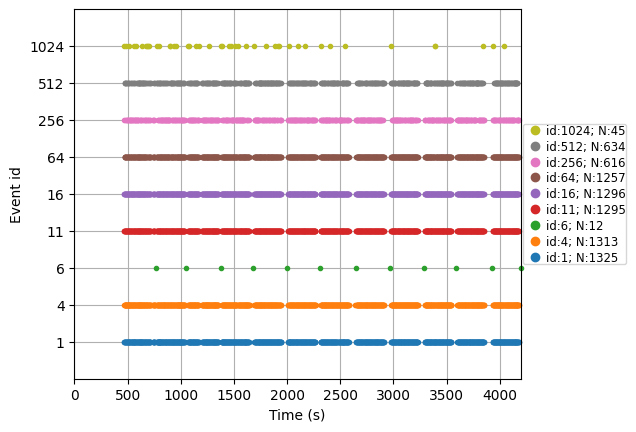

Adding metadata with 7 columns
1245 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1245 events and 2177 original time points ...
12 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=32


  0%|          | Repairing epochs : 0/1233 [00:00<?,       ?it/s]

Dropped 24 epochs: 223, 266, 302, 303, 540, 541, 542, 565, 566, 569, 590, 591, 637, 638, 669, 792, 793, 1014, 1015, 1026, 1067, 1197, 1198, 1199
Overwriting existing file.
Overwriting existing file.
Processing VP23
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6481 events found on stim channel Status
Event IDs: [ 1  4  6 11 16 64]


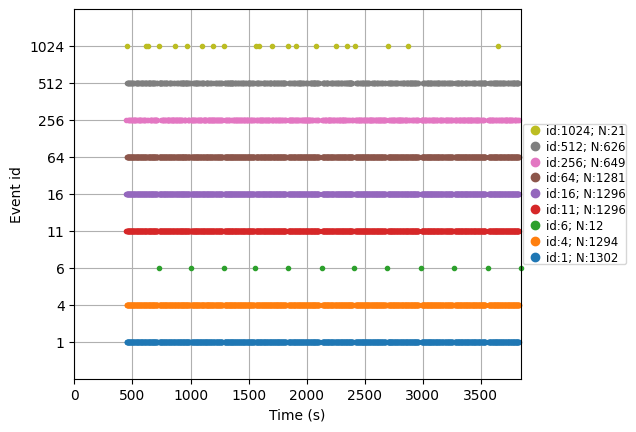

Adding metadata with 7 columns
1268 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1268 events and 2177 original time points ...
12 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1256 [00:00<?,       ?it/s]

Dropped 87 epochs: 26, 30, 32, 35, 36, 37, 38, 63, 65, 66, 71, 74, 75, 76, 138, 139, 181, 182, 208, 257, 258, 259, 261, 262, 263, 264, 266, 267, 268, 269, 270, 271, 272, 273, 274, 277, 278, 286, 292, 308, 415, 416, 417, 422, 423, 424, 480, 481, 490, 497, 538, 539, 540, 541, 626, 627, 651, 652, 653, 654, 656, 657, 661, 665, 666, 671, 673, 674, 675, 676, 677, 678, 679, 966, 967, 1041, 1042, 1043, 1044, 1066, 1067, 1068, 1083, 1132, 1189, 1190, 1191
Overwriting existing file.
Overwriting existing file.
Processing VP21
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6458 events found on stim channel Status
Event IDs: [ 1  4  6 11 16 64]


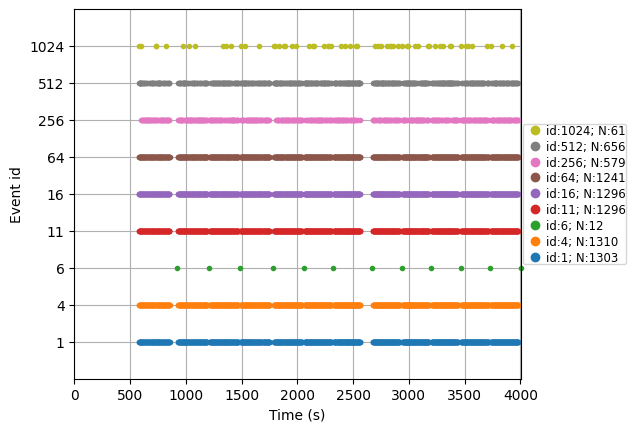

Adding metadata with 7 columns
1233 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1233 events and 2177 original time points ...
11 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=32


  0%|          | Repairing epochs : 0/1222 [00:00<?,       ?it/s]

Dropped 19 epochs: 188, 189, 376, 508, 543, 544, 548, 549, 615, 616, 677, 678, 794, 795, 796, 797, 863, 975, 1161
Overwriting existing file.
Overwriting existing file.
Processing VP18
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6470 events found on stim channel Status
Event IDs: [ 1  4  6 11 16 64]


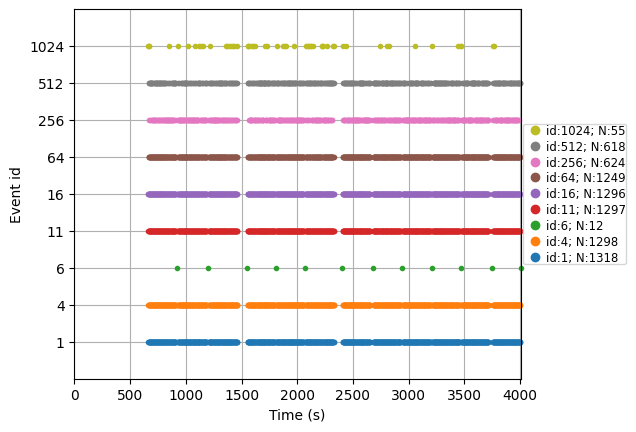

Adding metadata with 7 columns
1244 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1244 events and 2177 original time points ...
11 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1233 [00:00<?,       ?it/s]

Dropped 43 epochs: 203, 204, 305, 322, 447, 448, 450, 494, 495, 500, 501, 518, 519, 562, 563, 566, 622, 623, 719, 720, 766, 767, 808, 809, 828, 855, 856, 857, 914, 915, 916, 917, 933, 934, 955, 956, 1021, 1022, 1063, 1064, 1219, 1220, 1221
Overwriting existing file.
Overwriting existing file.
Processing VP10
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6582 events found on stim channel Status
Event IDs: [ 1  4  6 11 16 64]


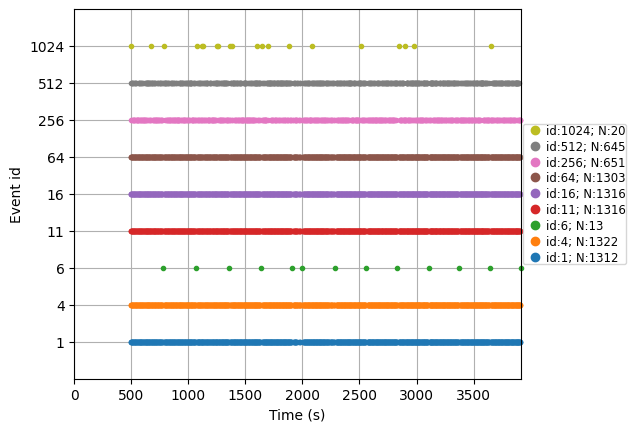

Adding metadata with 7 columns
1285 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1285 events and 2177 original time points ...
12 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=32


  0%|          | Repairing epochs : 0/1273 [00:00<?,       ?it/s]

Dropped 20 epochs: 330, 351, 362, 363, 534, 535, 553, 608, 626, 742, 745, 901, 934, 1001, 1002, 1066, 1092, 1093, 1134, 1135
Overwriting existing file.
Overwriting existing file.
Processing VP19
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6489 events found on stim channel Status
Event IDs: [ 1  4  6 11 16 64]


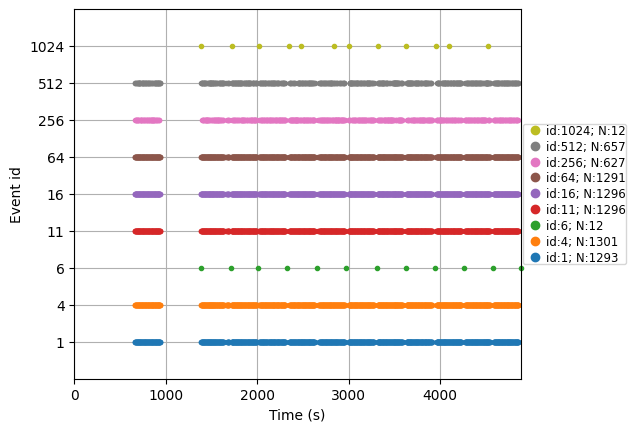

Adding metadata with 7 columns
1278 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1278 events and 2177 original time points ...
11 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=1.00 and n_interpolate=1


  0%|          | Repairing epochs : 0/1267 [00:00<?,       ?it/s]

Dropped 33 epochs: 0, 1, 2, 3, 5, 6, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 90, 91, 95, 1249, 1250
Overwriting existing file.
Overwriting existing file.
Processing VP17
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6436 events found on stim channel Status
Event IDs: [ 1  4  6 11 16 64]


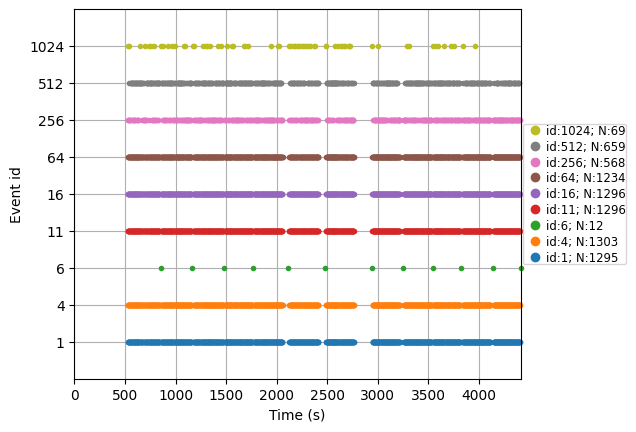

Adding metadata with 7 columns
1220 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1220 events and 2177 original time points ...
12 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1208 [00:00<?,       ?it/s]

Dropped 518 epochs: 43, 44, 46, 47, 48, 49, 50, 51, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 83, 84, 85, 86, 87, 88, 89, 90, 93, 94, 95, 96, 97, 98, 99, 100, 104, 105, 106, 109, 110, 112, 113, 114, 115, 116, 117, 118, 123, 124, 125, 126, 127, 128, 129, 130, 133, 134, 135, 136, 137, 139, 140, 141, 143, 149, 150, 151, 160, 161, 162, 163, 166, 167, 169, 170, 171, 172, 173, 174, 178, 179, 191, 197, 198, 202, 204, 205, 206, 207, 208, 209, 213, 216, 217, 219, 222, 227, 228, 229, 230, 231, 236, 237, 245, 247, 248, 249, 250, 257, 260, 261, 264, 265, 267, 268, 269, 270, 276, 278, 285, 286, 288, 289, 295, 296, 297, 311, 312, 318, 319, 320, 321, 323, 339, 346, 349, 350, 358, 359, 362, 363, 364, 366, 367, 369, 370, 371, 377, 378, 379, 380, 383, 384, 387, 388, 389, 390, 391, 392, 396, 404, 414, 419, 420, 421, 422, 425, 426, 427, 429, 430, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 455, 456, 457, 458, 459, 460, 461, 

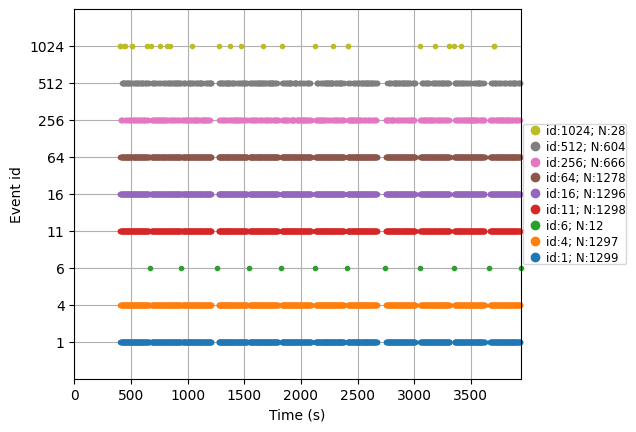

Adding metadata with 7 columns
1270 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1270 events and 2177 original time points ...
12 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1258 [00:00<?,       ?it/s]

Dropped 4 epochs: 309, 310, 1139, 1140
Overwriting existing file.
Overwriting existing file.
Processing VP9
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6484 events found on stim channel Status
Event IDs: [ 1  4  6 11 16 64]


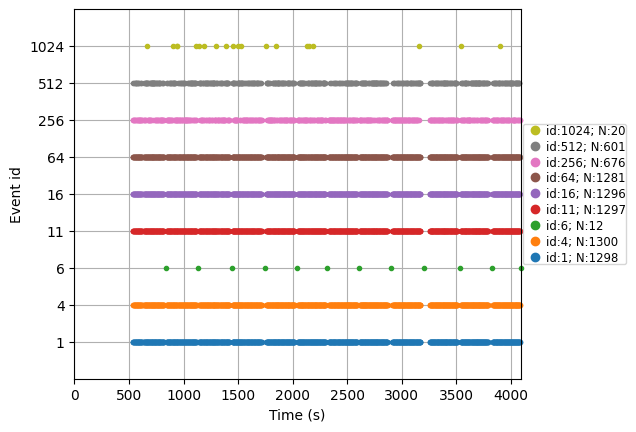

Adding metadata with 7 columns
1274 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1274 events and 2177 original time points ...
12 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1262 [00:00<?,       ?it/s]

Dropped 79 epochs: 6, 12, 13, 21, 22, 26, 27, 28, 31, 57, 58, 63, 64, 65, 66, 74, 75, 91, 97, 98, 116, 117, 123, 124, 125, 126, 155, 156, 161, 162, 171, 172, 184, 189, 208, 221, 247, 248, 295, 321, 326, 348, 366, 371, 372, 383, 387, 388, 396, 414, 431, 444, 445, 574, 575, 634, 635, 658, 659, 687, 709, 710, 745, 746, 778, 808, 829, 865, 866, 870, 871, 873, 874, 891, 914, 915, 936, 937, 994
Overwriting existing file.
Overwriting existing file.
Processing VP7
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6492 events found on stim channel Status
Event IDs: [ 1  4  6 11 16 64]


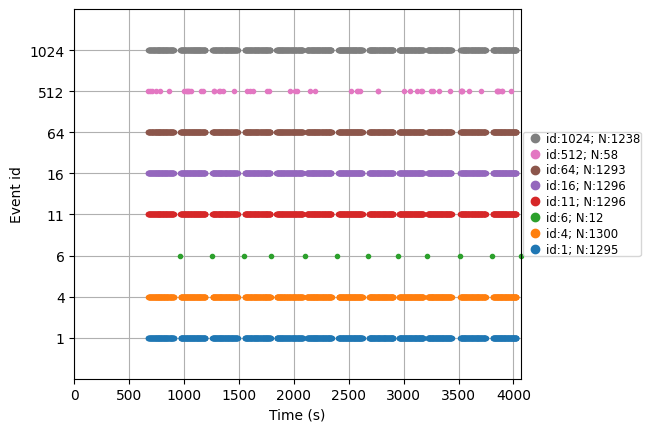

Adding metadata with 7 columns
100 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 100 events and 2177 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/100 [00:00<?,       ?it/s]

Dropped 46 epochs: 29, 30, 40, 41, 44, 45, 48, 49, 50, 52, 53, 54, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99
Overwriting existing file.
Overwriting existing file.
Processing VP22
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6488 events found on stim channel Status
Event IDs: [ 1  4  6 11 16 64]


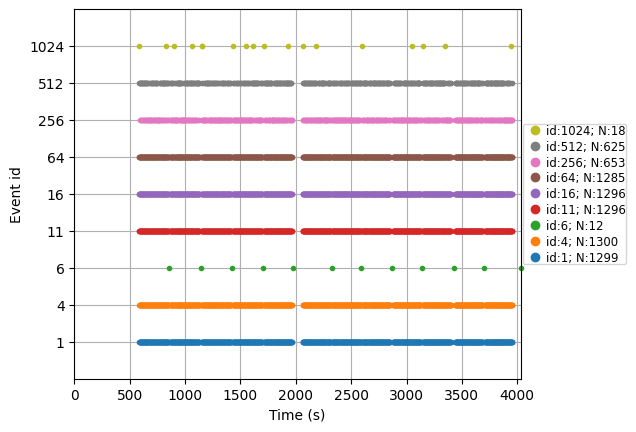

Adding metadata with 7 columns
1277 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1277 events and 2177 original time points ...
12 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1265 [00:00<?,       ?it/s]

Dropped 70 epochs: 20, 22, 29, 30, 212, 301, 471, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 602, 656, 657, 758, 759, 811, 841, 842, 843, 844, 845, 846, 898, 899, 900, 901, 1016, 1044, 1045, 1046, 1047, 1051, 1159, 1163, 1167, 1168, 1169, 1170, 1174, 1175, 1237, 1263, 1264
Overwriting existing file.
Overwriting existing file.
Processing VP20
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6494 events found on stim channel Status
Event IDs: [ 1  4  6 11 16 64]


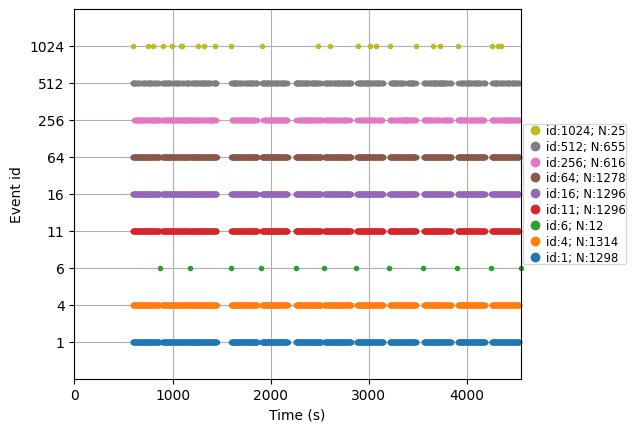

Adding metadata with 7 columns
1264 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1264 events and 2177 original time points ...
12 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1252 [00:00<?,       ?it/s]

Dropped 107 epochs: 46, 47, 171, 172, 195, 238, 239, 251, 252, 268, 270, 283, 284, 301, 302, 336, 352, 362, 375, 376, 383, 384, 385, 390, 391, 425, 442, 443, 444, 445, 455, 456, 504, 505, 506, 507, 511, 512, 526, 527, 608, 609, 610, 614, 648, 674, 708, 723, 724, 741, 742, 750, 751, 755, 762, 763, 788, 789, 791, 792, 805, 815, 818, 821, 831, 832, 857, 860, 861, 869, 895, 896, 907, 908, 909, 910, 911, 923, 937, 943, 947, 953, 978, 979, 980, 998, 999, 1002, 1077, 1100, 1102, 1103, 1104, 1116, 1117, 1134, 1135, 1144, 1146, 1147, 1178, 1195, 1211, 1212, 1227, 1228, 1249
Overwriting existing file.
Overwriting existing file.
Processing VP1
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
5399 events found on stim channel Status
Event IDs: [ 1  4  6 11 16 18 64]


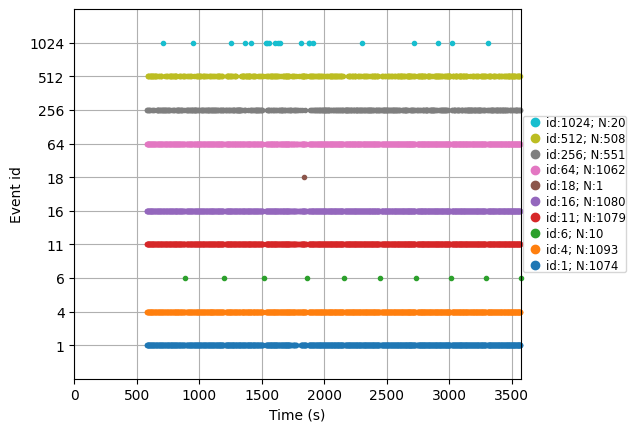

Adding metadata with 7 columns
1044 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1044 events and 2177 original time points ...
10 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1034 [00:00<?,       ?it/s]

Dropped 166 epochs: 62, 95, 96, 104, 105, 146, 153, 154, 202, 219, 220, 240, 246, 247, 248, 282, 338, 348, 365, 366, 375, 378, 388, 399, 406, 411, 412, 439, 482, 483, 495, 496, 499, 500, 507, 508, 509, 512, 521, 526, 527, 528, 529, 530, 534, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 549, 556, 563, 564, 597, 610, 631, 636, 637, 667, 668, 682, 708, 713, 714, 715, 722, 723, 727, 730, 734, 735, 736, 737, 741, 742, 743, 744, 745, 746, 748, 749, 752, 753, 754, 757, 760, 761, 762, 763, 764, 765, 766, 769, 770, 773, 774, 776, 777, 779, 780, 781, 787, 796, 797, 800, 802, 803, 804, 806, 808, 809, 811, 812, 813, 814, 816, 817, 818, 819, 820, 825, 830, 831, 849, 855, 856, 860, 861, 871, 872, 883, 884, 893, 896, 910, 911, 917, 920, 928, 933, 934, 937, 938, 939, 941, 942, 949, 951, 953, 955, 962, 965, 966, 969, 973, 974, 1009, 1010, 1011, 1023
Overwriting existing file.
Overwriting existing file.
Processing VP12
Trigger channel Status has a non-zero initial value of 65536 (consider using ini

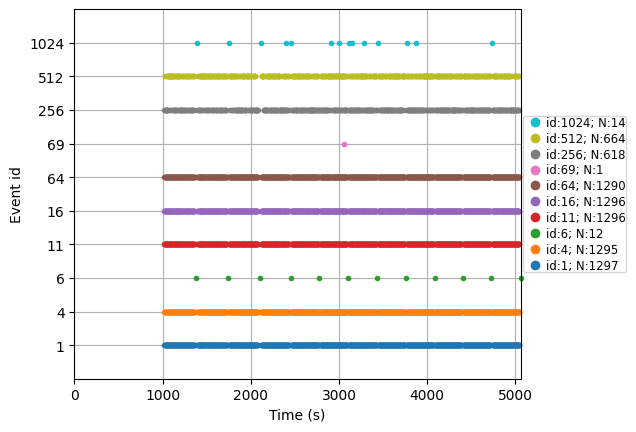

Adding metadata with 7 columns
1276 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1276 events and 2177 original time points ...
12 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1264 [00:00<?,       ?it/s]

Dropped 188 epochs: 31, 32, 33, 34, 109, 110, 111, 112, 113, 114, 116, 117, 118, 119, 120, 121, 128, 132, 136, 138, 139, 140, 146, 147, 148, 150, 151, 155, 157, 159, 165, 169, 170, 171, 174, 175, 176, 178, 179, 180, 182, 183, 184, 185, 189, 190, 191, 204, 210, 211, 212, 217, 218, 223, 224, 225, 227, 228, 231, 232, 233, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 247, 248, 249, 252, 253, 254, 255, 256, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 275, 276, 277, 278, 279, 281, 282, 283, 284, 286, 289, 290, 291, 292, 293, 295, 296, 297, 298, 299, 302, 304, 305, 306, 307, 308, 314, 315, 321, 322, 323, 326, 327, 337, 338, 339, 340, 341, 342, 343, 344, 346, 347, 349, 350, 351, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 367, 368, 370, 371, 375, 376, 380, 381, 382, 383, 384, 385, 386, 388, 389, 390, 392, 393, 394, 395, 397, 399, 402, 404, 405, 406, 407, 409, 410, 411, 526, 550, 551, 686
Overwriting existing file.
Overwriting existi

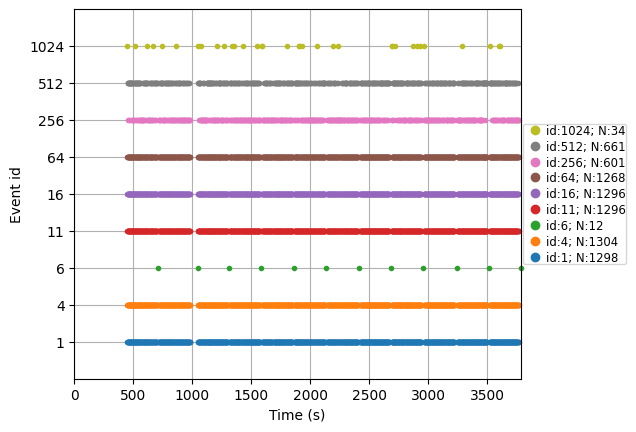

Adding metadata with 7 columns
1259 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1259 events and 2177 original time points ...
12 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1247 [00:00<?,       ?it/s]

Dropped 9 epochs: 618, 623, 624, 625, 788, 936, 1053, 1143, 1144
Overwriting existing file.
Overwriting existing file.
Processing VP2
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6473 events found on stim channel Status
Event IDs: [ 1  4  6 11 16 64]


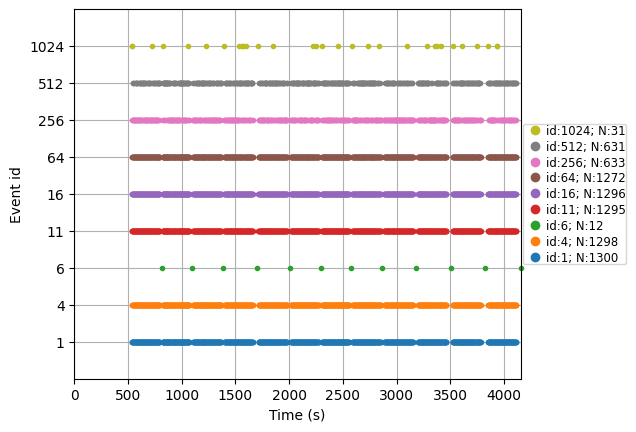

Adding metadata with 7 columns
1264 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1264 events and 2177 original time points ...
12 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1252 [00:00<?,       ?it/s]

Dropped 20 epochs: 287, 288, 313, 348, 349, 403, 517, 518, 519, 662, 690, 700, 701, 809, 810, 811, 845, 846, 1199, 1200
Overwriting existing file.
Overwriting existing file.


In [4]:
tmin = -0.25
tmax = 2
logs_path = DATA_PATH / "prp/behavior"
for subj in subj_names[1:]:
    print(f'Processing {subj}')
    raw = mne.io.read_raw_fif(path / f"post_ica_{subj}_raw.fif", preload=True, verbose=False)

    # # stimulus/t1 > response/t1
    # epochs, events = create_epochs_t1(tmin, tmax, raw, logs_path)
    # epochs = autoreject(epochs, raw)
    # epochs.save(out_path / f"{subj}-t1-epo.fif", overwrite=True)

    # # stimulus/t2 > response/t2
    # epochs, events = create_epochs_t2(tmin, tmax, raw, logs_path) 
    # epochs = autoreject(epochs, raw)
    # epochs.save(out_path / f"{subj}-t2-epo.fif", overwrite=True)

    # stimulus/t1 > response/t2
    epochs, events = create_epochs_combined(tmin, 4, raw, logs_path) 
    epochs = autoreject(epochs, raw)
    epochs.save(out_path / f"{subj}-t-epo.fif", overwrite=True)

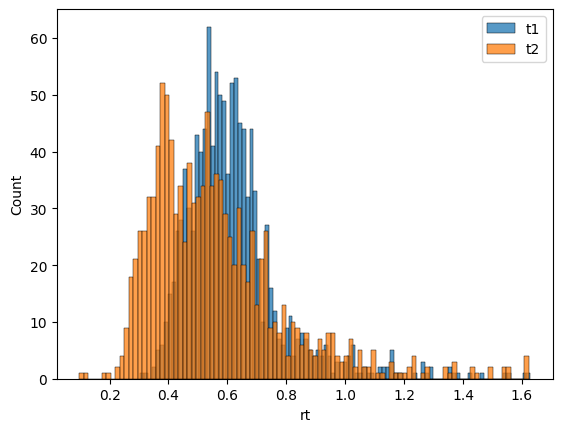

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(epochs.metadata.rt, bins=100, label='t1')
sns.histplot(epochs_t2.metadata.rt, bins=100, label='t2')
plt.legend()
plt.show()

### DEBUGGING

In [117]:
cnt = 0
for subj in subj_names:
    print(subj)
    raw = mne.io.read_raw_fif(path / f"post_ica_{subj}_raw.fif", preload=True, verbose=False)
    print(raw['stim'])
    print(raw.ch_names)
    stim_idx = raw.ch_names.index('Status')
    res = merge_events_stim(raw['Status'])
    raw._data[stim_idx] = res[0]
    print(res[0][:,414450:414480])
    print(raw['stim'][0][:,414450:414480])
    print(raw['Status'][0][:,414450:414480])
    # Consecutive? Assumes that trial onset is first, probably very unlikely that two numbers in sequence will be non-zero so doesn't matter?
    # Q LEENDERT: 
    events = mne.find_events(raw, shortest_event=1)
    events_cons = mne.find_events(raw, shortest_event=1, consecutive=True)
    events = merge_events(events)
    events_cons = merge_events(events_cons)
    # print(events[:,2][:100])
    # print(events_cons[:,2][:100])
    # print(np.unique(events[:,2], return_counts=True))
    # print(np.unique(events_cons[:,2], return_counts=True))
    
    for i in range(1, len(events)):
        if events[i-1, 2] == 64 and events[i, 2] == 64:
            print(events[i-1], events[i])
            cnt += 1
    break
    # for i in range(0, events_cons.shape[0], 100):
    #     print(i)
    #     events_subset = events[i:i+100]
    #     cons_subset = events_cons[i:i+100]
    #     if (events_subset != cons_subset).any():
    #         print(events_subset[:,2])
    #         print(cons_subset[:,2])
    #         print(events_subset[:,0])
    #         print(cons_subset[:,0])
    #         break
    
print(cnt)

VP10
(array([[65536., 65536., 65536., ...,     0.,     0.,     0.]]), array([0.00000000e+00, 1.95312500e-03, 3.90625000e-03, ...,
       3.94999414e+03, 3.94999609e+03, 3.94999805e+03]))
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status', 'eog_h', 'eog_v']
[[ 0.  0.  0.  0.  0. 64. 64. 64. 64. 64. 64. 64. 64. 64. 64. 64.  1.  1.
   1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0. 64. 64. 64. 64. 64. 64. 64. 64. 64. 64. 64.  1.  1.
   1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0. 64. 64. 64. 64. 64. 64. 64. 64. 64. 64. 64.  1.  1.
   1.  1.  1.  1.  0.  0.  0.  0.  0.  0. 

In [91]:
raw['stim'][0]

array([[65536., 65536., 65536., ...,     0.,     0.,     0.]])

In [97]:
raw['stim'][0][:,414450:414480]

array([[ 0.,  0.,  0.,  0.,  0., 64., 64., 64., 64., 64., 64., 67., 67.,
        67., 67., 67.,  3.,  3.,  3.,  3.,  3.,  3.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]])

244 TOTAL occurences where 64 follows 64, 153 if consecutive='increasing' (stim t2), what does this mean?
Likely cases where 64 is followed by not 64 (but a value that is corrected to 64 in merge_events)
solution: merge_events BEFORE find_events

1/2/3 + = 14.392 (all responses t1)
4/5 + = 14.529 (all responses t2)
6 = new block?
11/12/21/22/31/32 += stim t1
130/129/128/67/66/64 (should be 64/128, failure when transmitting int?) = stim t2
16: fixation cross
Normal trial = 16-11-64-1-4/16-11-1-64-4
ALWAYS 16 (fixation) 11 (stim t1) > 1 (resp t1) OR 64 (stim t2) > 4
Not all response events were recorded, participant was too slow? Should not count trials where this is the case

In [33]:
raw['Status'][0]

array([[65536., 65536., 65536., ...,     0.,     0.,     0.]])

In [49]:
raw.info

Measurement date,"November 28, 2016 15:09:22 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,67 points
Good channels,"64 EEG, 1 Stimulus, 2 EOG"
Bad channels,None
EOG channels,"eog_h, eog_v"
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,1.00 Hz
Lowpass,100.00 Hz


In [40]:
np.unique(raw['Status'][0].astype(int), return_counts=True)
# 1/2/3 + = 14.392 (all responses t1)
# 4/5 + = 14.529 (all responses t2)
# 6 = new block?
# 11/12/21/22/31/32 += stim t1
# 130/129/128/67/66/64 (should be 64/128, failure when transmitting int?) = stim t2
# 16: fixation cross

(array([    0,     1,     2,     3,     4,     5,     6,    11,    12,
           16,    21,    22,    31,    32,    64,    66,    67,   128,
          129,   130, 65536]),
 array([1949969,    4647,    4990,    4755,    7263,    7266,     143,
           2451,    2384,   14466,    2394,    2418,    2395,    2418,
           7174,       6,       5,    7115,      15,       6,     120],
       dtype=int64))

In [52]:
raw.info

Measurement date,"November 28, 2016 15:09:22 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,67 points
Good channels,"64 EEG, 1 Stimulus, 2 EOG"
Bad channels,None
EOG channels,"eog_h, eog_v"
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,1.00 Hz
Lowpass,100.00 Hz


In [ ]:
tmin = -0.25
tmax = 2

for subj in subj_names:
    # Skip those subjects because the data is not valid
    if subj == 'VP6' or subj == 'VP7':
        continue

    raw = mne.io.read_raw_fif(path+"Post ICA/post_ica_%s_raw.fif"%subj, preload=True)
    # epoch = mne.read_epochs(epoch_data_path+subj+'.fif')

    # ================= STIMULUS 1 =================
    epochs, events = create_epochs_t1(tmin, tmax, raw)
    epochs = autoreject(epochs, raw)
    epochs.save(path+'Stimlocked_fixed_index/%s_epo_t1.fif'%subj, overwrite=True)

    # # ================= STIMULUS 2 =================
    epochs, events = create_epochs_t2(tmin, tmax, raw)
    epochs = autoreject(epochs, raw)
    epochs.save(path+'Stimlocked_fixed_index/%s_epo_t2.fif'%subj, overwrite=True)

    # ================= WHOLE TRIALS =================
    # epochs, events = create_epochs_trial(tmin, tmax, raw)
    # epochs = autoreject(epochs, raw)
    # epochs.save(path+'Stimlocked_fixed_index/%s_epo_trial.fif'%subj, overwrite=True)